In [82]:
# Load libraries
import torch 
import pandas as pd 
import numpy as np
import json
import tokenizers


from torch import tensor
from torch.utils.data import DataLoader, Dataset
from transformers import  RobertaConfig
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.models import WordLevel, BPE
from tokenizers import pre_tokenizers, normalizers, Tokenizer
from tokenizers.normalizers import Lowercase, NFD
from tokenizers.pre_tokenizers import ByteLevel, Whitespace
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from utils.utils import prob2label
import matplotlib.pyplot as plt


In [14]:
# Load settings
with open('settings.json', 'r') as inFile:
    settings = json.load(inFile)
    
# Set device 
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load model
model = torch.load('best_model')
model.to(device)
model.eval()

Net(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(26, 1024, padding_idx=1)
      (position_embeddings): Embedding(512, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), 

In [15]:
class CDR3Dataset(Dataset):
    
    def __init__(self, settings:dict, train:bool = True, label:str = None, tokenizer:tokenizers.Tokenizer=None, equal:bool=False) -> None:
        cols = ["activatedby_HA", "activatedby_NP", "activatedby_HCRT", "activated_any", "multilabel", "negative"]
        if label not in cols:
            raise ValueError("Invalid label type. Expected one of %s" % cols)
        else: 
            self.label = label
        if equal and label == "num_label":
            raise ValueError("Equal size sets only allowed for binary classifications. num_label is multiclass.")
        
        if train == True:
            path_to_data = settings["file"]["train_data"] 
        else:
            path_to_data = settings["file"]["test_data"]   
              
        self.path_to_data = path_to_data
        self.data = pd.read_csv(self.path_to_data)
        if equal == True:
            min_sample=np.min(self.data[self.label].value_counts()) 
            data_pos = self.data[self.data[self.label]==1].sample(min_sample)
            data_neg = self.data[self.data[self.label]==0].sample(min_sample)
            self.data = pd.concat([data_pos, data_neg], ignore_index=True)
        
        if label == "multilabel":
            self.labels = [0,1]
            self.n_labels = 3
        else:
            self.labels = np.unique(self.data[[self.label]])
            self.n_labels = len(self.labels)
            
        self.max_len = self.data.CDR3ab.str.len().max()
        
        self.tokenizer = tokenizer
        
    def __getitem__(self, index:int):
        if isinstance(self.tokenizer.model, tokenizers.models.WordLevel):
            self.tokenizer.enable_padding(length=self.max_len)
            CDR3ab = " ".join(list(self.data.CDR3ab[index]))
            encodings = self.tokenizer.encode(CDR3ab)
            item = {
                "ids":tensor(encodings.ids, dtype=torch.long),
                "attention_mask": tensor(encodings.attention_mask, dtype=torch.long),
                "CDR3ab": self.data.CDR3ab[index]
                }
        elif isinstance(self.tokenizer.model, tokenizers.models.BPE):
            self.tokenizer.enable_padding(length=self.max_len)
            encodings = self.tokenizer.encode(self.data.CDR3ab[index]) 
            item = {
                "ids":tensor(encodings.ids, dtype=torch.long),
                "attention_mask": tensor(encodings.attention_mask, dtype=torch.long),
                "CDR3ab": self.data.CDR3ab[index]
                }
        if self.label == "multilabel":
            item["target"]=tensor(self.data[["activatedby_HA", "activatedby_NP", "activatedby_HCRT"]].iloc[index],dtype =torch.long)
        else:
            item["target"] = tensor(self.data[self.label][index], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.data)

In [16]:
# Create tonekizer from tokenizers library 
if settings["param"]["tokenizer"] == "BPE":
    tokenizer = Tokenizer(BPE()).from_file(settings["tokenizer"]["BPE"])
elif settings["param"]["tokenizer"] == "WL":
    tokenizer = Tokenizer(WordLevel()).from_file(settings["tokenizer"]["WL"])
else:
    raise ValueError("Unknown tokenizer. Tokenizer argument must be BPE or WL.")
tokenizer.enable_padding()
    
# Create training and test dataset
dataset_params={"label":settings["database"]["label"], "tokenizer":tokenizer}
train_data = CDR3Dataset(settings,train=True, equal=False, **dataset_params)
test_data =CDR3Dataset(settings, train=False, **dataset_params)

# Crate dataloaders
loader_params = {'batch_size': 20,
            'shuffle': True,
            'num_workers': 0
            }
train_dataloader = DataLoader(train_data, **loader_params)
test_dataloader = DataLoader(test_data, **loader_params)

In [56]:
# Get 10 random CDRs and predict 
sample_train = next(iter(train_dataloader))

# Predict 
torch.cuda.empty_cache() 
model.eval()
outs_df = []
ids = sample_train["ids"].to(device)
attention_mask = sample_train["attention_mask"].to(device)
targets = sample_train["target"].to(device)
outs = model(ids, attention_mask)

# Bring to CPU 
targets = targets.to('cpu') .detach().numpy()
outs = outs.to('cpu')
outs = outs.detach().numpy()
outs = np.around(outs, decimals=3) 

cols_prob = ["PROB_activatedby_HA", "PROB_activatedby_NP", "PROB_activatedby_HCRT"]
cols = ["activatedby_HA", "activatedby_NP", "activatedby_HCRT"]

# Crate dataframes 
outs_df = pd.DataFrame.from_records(outs)
outs_df.columns = cols_prob

# Crate dataframe of targets
targets_df = pd.DataFrame.from_records(targets)
targets_df.columns = cols
targets_df.insert(0, 'CDR3ab', sample_train['CDR3ab'])

# Concat 
comp_df = pd.concat([targets_df, outs_df], axis=1)
comp_df



,CDR3ab,activatedby_HA,activatedby_NP,activatedby_HCRT,PROB_activatedby_HA,PROB_activatedby_NP,PROB_activatedby_HCRT
0,CAGHPAAGNKLTF_CASSDRTGFGTEAFF,0,0,0,0.000,0.000,0.000
1,CACSEGFQKLVF_CASSENGAKETQYF,0,0,0,0.001,0.001,0.001
2,CAGMNAGGTSYGKLTF_CAISGLAGGFYEQYF,0,0,0,0.001,0.000,0.000
3,CAASDPSGNTPLVF_CASSLGGLDEKLFF,0,0,0,0.000,0.000,0.000
4,CALNSGGGADGLTF_CASSPGTSRRYEQYF,0,0,0,0.001,0.000,0.000
5,CAVSAPSGTGNQFYF_CASSYSGGPGGYTF,0,0,0,0.003,0.000,0.001
6,CAATGGYNKLIF_CASSTGQTQETQYF,0,0,1,0.000,0.000,1.000
7,CVVSVGGTYKYIF_CASSFGTPSSYEQYF,0,0,0,0.001,0.000,0.000
8,CAVETDSWGKLQF_CASSLRDSSYNEQFF,0,0,0,0.001,0.000,0.000
9,CAYNAGGTSYGKLTF_CASSRPTGAYEQYF,0,0,0,0.002,0.000,0.000


In [20]:

# Get 10 random CDRs and predict 
sample_test = next(iter(test_dataloader))

# Predict 
model.eval()
outs_df = []
ids = sample_test["ids"].to(device)
attention_mask = sample_test["attention_mask"].to(device)
targets = sample_test["target"].to(device)
outs = model(ids, attention_mask)

# Bring to CPU 
targets = targets.to('cpu') .detach().numpy()
outs = outs.to('cpu')
outs = outs.detach().numpy()
outs = np.around(outs, decimals=3) 

cols_prob = ["PROB_activatedby_HA", "PROB_activatedby_NP", "PROB_activatedby_HCRT"]
cols = ["activatedby_HA", "activatedby_NP", "activatedby_HCRT"]

# Crate dataframes 
outs_df = pd.DataFrame.from_records(outs)
outs_df.columns = cols_prob

# Crate dataframe of targets
targets_df = pd.DataFrame.from_records(targets)
targets_df.columns = cols
targets_df.insert(0, 'CDR3ab', sample_test['CDR3ab'])

# Concat 
comp_df = pd.concat([targets_df, outs_df], axis=1)
comp_df



CDR3ab  activatedby_HA  activatedby_NP  \
0       CAVWPGGGADGLTF_CASSPTEETQYF               0               1   
1       CAGRFSDGQKLLF_CASSPGQNYGYTF               0               0   
2      CAVSPYNTDKLIF_CASSLGGSTYEQYF               1               0   
3       CAVQARSWGKLQF_CASTGSYNSPLHF               0               0   
4   CALSDNSGAGSYQLTF_CASSYSGGKETQYF               0               0   
5       CAAPNQAGTALIF_CASSLSRVDEQFF               1               0   
6      CAARDSGYSTLTF_CASSASTGGALQFF               0               1   
7    CAESRGTGRRALTF_CASSWVGTGDQPQHF               0               1   
8     CLLPHYSGAGSYQLTF_CASSRTAGELFF               0               0   
9    CAVAPGGGADGLTF_CASSPSGGRNEKLFF               0               0   
10    CALSADGGATNKLIF_CASSGTGKYEQYF               0               1   
11     CAVGEYGNKLVF_CASSPPGTVSQPQHF               0               1   
12      CLLISGTYKYIF_CASSLWTPVGEQYF               0               0   
13      CILRAGGKLIF_CASSQGARGTDTQYF               1               0   
14      CAGKVGNEKLTF_CASDTSGRADTQYF               0               0   
15     CATDADDYKLSF_CSASQGRGTTNEQYF               0               0   
16   CALCSGGGADGLTF_CASSLEGGSSYEQYF               0               0   
17   CAESPFMQGGKLIF_CASSGGTDSNQPQHF               1               0   
18     CAVQTGTASKLTF_CASRRTLGHDTQYF               0               0   
19       CAYSDRDDKIIF_CATTGWRGTEAFF               0               0   

    activatedby_HCRT  PROB_activatedby_HA  PROB_activatedby_NP  \
0                  0                0.000                1.000   
1                  0                0.054                0.001   
2                  0                0.998                0.000   
3                  1                0.000                0.000   
4                  0                0.001                0.000   
5                  0                0.999                0.000   
6                  0                0.000                0.290   
7                  0                0.000                1.000   
8                  0                0.001                0.000   
9                  0                0.000                0.000   
10                 0                0.001                0.000   
11                 0                0.000                1.000   
12                 1                0.000                0.000   
13                 0                0.902                0.000   
14                 0                0.002                0.000   
15                 0                0.000                0.000   
16                 0                0.001                0.000   
17                 0                0.014                0.001   
18                 0                0.000                0.001   
19                 0                0.000                0.523   

    PROB_activatedby_HCRT  
0                   0.000  
1                   0.002  
2                   0.000  
3                   1.000  
4                   0.000  
5                   0.000  
6                   0.003  
7                   0.000  
8                   0.000  
9                   0.000  
10                  0.124  
11                  0.000  
12                  1.000  
13                  0.000  
14                  0.115  
15                  0.000  
16                  0.000  
17                  0.001  
18                  0.000  
19                  0.024

In [41]:
# Train data 
train_data.data.activated_by.value_counts()

negative      2783
NP136          766
HA69           535
HCRT           269
HCRT|NP136      33
HA69|NP136      28
HA69|HCRT        6
Name: activated_by, dtype: int64

In [26]:
train_data.data.shape[0]

4420

In [38]:
test_data.data.activated_by.value_counts()

negative      1174
NP136          365
HA69           192
HCRT           143
HA69|NP136      14
HCRT|NP136       6
Name: activated_by, dtype: int64

In [27]:
test_data.data.shape[0]

1894

In [48]:
test_data.data.activatedby_NP.value_counts()

1    1682
0     212
Name: activatedby_NP, dtype: int64

In [62]:
# Get all predictions for test and train set 
out_train, out_test = [], []
targets_train, targets_test = [],[]
fpr_train, fpr_test = [], []
tpr_train, tpr_test = [], []
out_prob = []
model.eval()

for data in train_dataloader:
    ids = data["ids"].to(device)
    attention_mask = data["attention_mask"].to(device)
    targets = data["target"].to(device)
    outs = model(ids, attention_mask)
    targets = targets.to('cpu') .detach().numpy().tolist()
    outs = outs.to('cpu')
    outs = outs.detach().numpy()
    out_label = prob2label(outs, threshold=0.5)
    out_train += out_label
    targets_train += targets


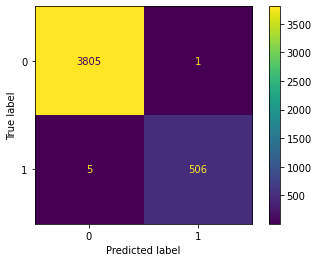

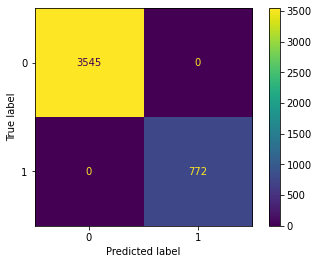

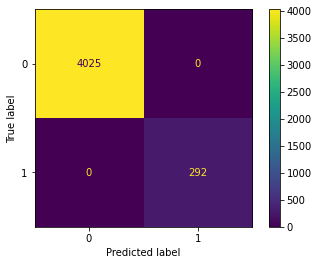

In [63]:
mlcf = multilabel_confusion_matrix(np.array(targets_train), np.array(out_train))
%matplotlib inline
for i in range(len(mlcf)):
    disp = ConfusionMatrixDisplay(mlcf[i], )
    disp.plot()


In [65]:
# Get all predictions for test and train set 
for data in test_dataloader:
    ids = data["ids"].to(device)
    attention_mask = data["attention_mask"].to(device)
    targets = data["target"].to(device)
    outs = model(ids, attention_mask)
    targets = targets.to('cpu') .detach().numpy().tolist()
    outs = outs.to('cpu')
    outs = outs.detach().numpy()
    outs = np.around(outs, decimals=3)
    out_label = prob2label(outs, threshold=0.5)
    out_test += out_label
    targets_test += targets

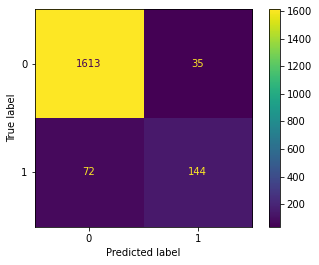

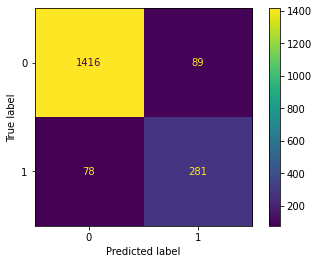

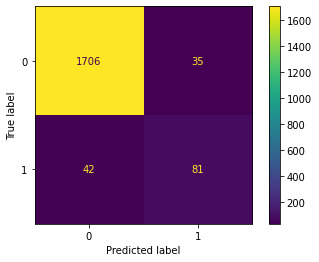

In [67]:
mlcf = multilabel_confusion_matrix(np.array(targets_test), np.array(out_test))

%matplotlib inline
for i in range(len(mlcf)):
    disp = ConfusionMatrixDisplay(mlcf[i])
    disp.plot()

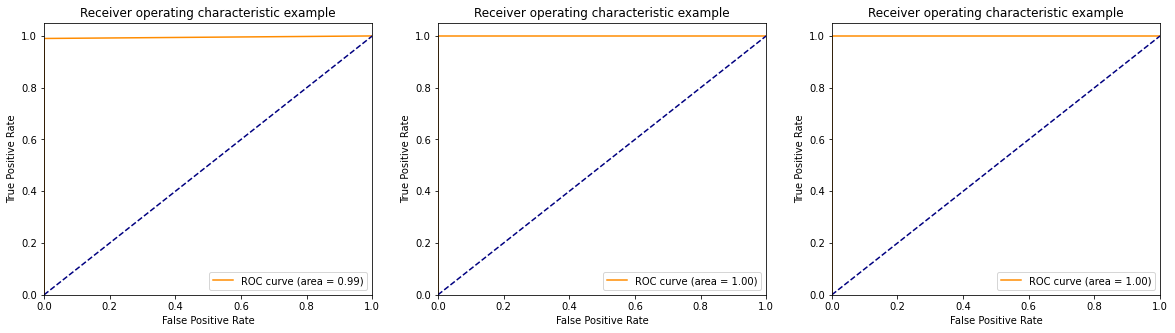

In [89]:
# Roc curve train 
out_train_flat = list(map(list, zip(*out_train)))
targets_train_flat = list(map(list, zip(*targets_train)))

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
for i in range(len(out_train_flat)):
    fpr, tpr, _ =roc_curve(targets_train_flat[i], out_train_flat[i])
    plt.subplot(1,3, i+1)
    plt.plot(fpr,tpr,color="darkorange",label="ROC curve (area = %0.2f)" % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
plt.show()

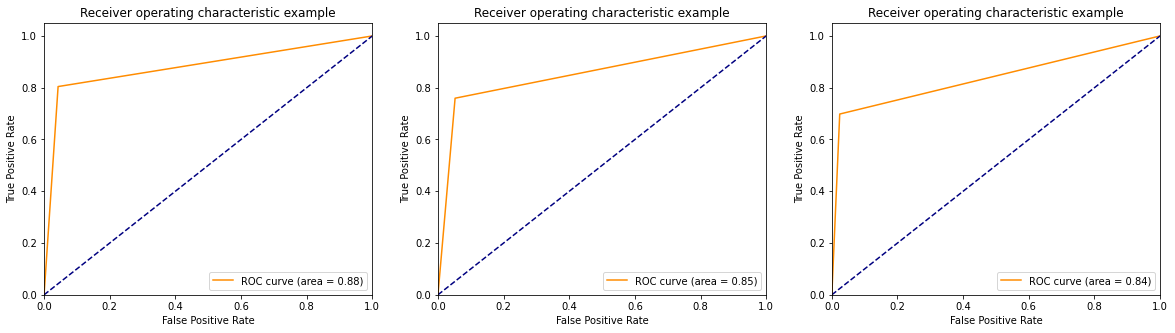

In [90]:
# Roc curve train 
out_test_flat = list(map(list, zip(*out_test)))
targets_test_flat = list(map(list, zip(*targets_test)))

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 5]
for i in range(len(out_train_flat)):
    fpr, tpr, _ =roc_curve(out_test_flat[i], targets_test_flat[i])
    plt.subplot(1,3, i+1)
    plt.plot(fpr,tpr,color="darkorange",label="ROC curve (area = %0.2f)" % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
plt.show()